In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
from rum.basics import matprint

# Aufgabe 1


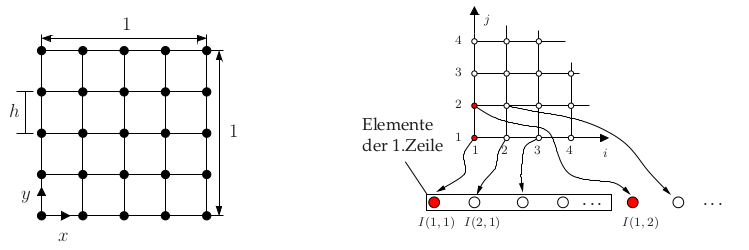

## a)
Generate a uniform grid

In [2]:
class UniformGrid():
    
    def __init__(self, xrange, yrange, h):
        self.h = h
        self.N = int(1/h) + 1
        self.xrange = xrange
        self.yrange = yrange
        self.shape = (self.N, self.N)

        self.grid_x = np.linspace(0,xrange,self.N)
        self.grid_y = np.linspace(0,xrange,self.N)
        
    
    def __iter__(self):
        "Unpacks to grid_x, grid_y, h"
        return iter((self.grid_x, self.grid_y, self.h))

    def __getitem__(self,index):
        try:
            i,j = index
        except TypeError as e:
            print("Index must be a tuple of ints, i.e. grid[i,j].")
            raise e
        return (self.grid_x[i], self.grid_y[j])
    
    
    def plot(self):
        fix, ax = plt.subplots()

        gridpoints = [self[i,j] for i in range(self.N) for j in range(self.N)]
        plot_x = [gp[0] for gp in gridpoints]
        plot_y = [gp[1] for gp in gridpoints]

        ax.set_xlabel('x')
        ax.set_ylabel('y')

        ax.scatter(plot_x, plot_y)
        return plt

In [3]:
grid = UniformGrid(10.0,10.0,0.01)
print(grid[0,1])
print(grid[5,5])
print(grid[9,9])

(0.0, 0.1)
(0.5, 0.5)
(0.9, 0.9)


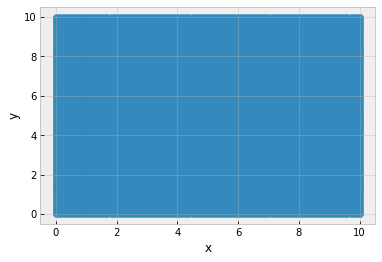

In [4]:
grid.plot().show()

## b)
Discrete Matrix operator DX

In [64]:
import copy


class Field(UniformGrid):

    def __init__(self, xrange, yrange, h,
                 initialvalues=None):
        super().__init__(xrange, yrange, h)

        self.values = np.zeros([self.N, self.N], dtype=np.float64)

        if not type(initialvalues == None):
            if type(initialvalues) == float:
                self.values.fill(float(initialvalues))
            else:
                raise ValueError("Incorrect argument for initialvalues")

    def asvector(self):
        return self.values.flatten()

    def getxy(self, i, j):
        return (self.grid_x[i], self.grid_y[j])

    def __iter__(self):
        "Unpacks to grid_x, grid_y, "
        return iter((self.grid_x, self.grid_y, self.h))

    def __setitem__(self, index, value):
        try:
            i, j = index
        except TypeError as e:
            print("Index must be a tuple of ints, i.e. field[i,j].")
            raise e
        self.values[i, j] = value

    def __getitem__(self, index):
        try:
            i, j = index
        except TypeError as e:
            print("Index must be a tuple of ints, i.e. field[i,j].")
            raise e
        return (self.values[i, j])

    def copy(self):
        return copy.deepcopy(self)

    def plot(self, colormap='cool'):
        fix, ax = plt.subplots()

        gridpoints = [self.getxy(i, j) for i in range(self.N)
                      for j in range(self.N)]
        plot_x = [gp[0] for gp in gridpoints]
        plot_y = [gp[1] for gp in gridpoints]

        ax.set_xlabel('x')
        ax.set_ylabel('y')

        ax.scatter(plot_x, plot_y, c=self.asvector(), cmap=colormap)
        return plt

    def dx(self):
        """
        returns a new field of the same size,
        containing the partial derivative of
        f w.r.t. x
        """
        d_values = DX(field.shape[0]).dot(field.asvector())
        d_field = self.copy()
        d_field.values = d_values.reshape(self.shape)
        return d_field
    
    def dy(self):
        """
        returns a new field of the same size,
        containing the partial derivative of
        f w.r.t. y
        """
        d_values = DY(field.shape[0]).dot(field.asvector())
        d_field = self.copy()
        d_field.values = d_values.reshape(self.shape)
        return d_field
    
    def diff(self):
        """
        returns a new field of the same size,
        containing the derivative of
        f w.r.t. x,y defined as 
        diff(f(x,y) = df(x,y)/dx + df(x,y)/dy
        """
        d_values = DIFF(field.shape[0]).dot(field.asvector())
        d_field = self.copy()
        d_field.values = d_values.reshape(self.shape)
        return d_field
      
    def lapl(self):
        """
        returns a new field of the same size,
        containing the derivative of
        f w.r.t. x,y defined as 
        diff(f(x,y) = df(x,y)/dx + df(x,y)/dy
        """
        d_values = LAPL(field.shape[0]).dot(field.asvector())
        d_field = self.copy()
        d_field.values = d_values.reshape(self.shape)
        return d_field

    @staticmethod
    def DX(N):
        diag0 = np.repeat([0], N)
        diag0[0] = -1
        diag0[-1] = 1
        diag1 = np.repeat([0.5], N-1)
        diag1[0] = 1
        diagm1 = np.repeat([-0.5], N-1)
        diagm1[-1] = -1
        mp_block = sparse.diags((diag0, diag1, diagm1), [0, 1, -1])
        DX = sparse.block_diag([mp_block.todense()]*N)
        return DX

    @staticmethod
    def DY(N):
        data = np.concatenate([[-1, 1], [-0.5, 0.5]*(N-2), [-1, 1]])
        iidx = np.repeat([N*i for i in range(0, N)], 2)
        j_middle = np.concatenate([[N*i, N*(i+2)] for i in range(0, N-2)])
        jidx = np.concatenate([[0, N], j_middle, [N*(N-2), N*(N-1)]])

        joined_iidx = np.concatenate(
            [iidx + np.ones(2*N, dtype=np.int_)*n for n in range(N)])
        joined_jidx = np.concatenate(
            [jidx + np.ones(2*N, dtype=np.int_)*n for n in range(N)])
        joined_data = np.tile(data, N)
        DY = sparse.coo_matrix((joined_data, (joined_iidx, joined_jidx)))
        return -1*DY

    @staticmethod
    def DIFF(N):
        return DX(N)+DY(N)

    @staticmethod
    def LAPL(N):
        dx = DX(N)
        dy = DY(N)
        return dx.dot(dx) + dy.dot(dy)

4.0


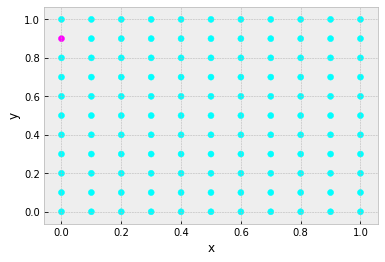

In [65]:
field = Field(1.0,1.0,0.1)
# assign value
field[0,9] = 4
# get value
print(field[0,9])
field.plot().show()

In [66]:
print(field.values)
print(field.asvector())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [67]:
def DX(N):
    diag0 = np.repeat([0],N); diag0[0] = -1; diag0[-1] = 1
    diag1 = np.repeat([0.5],N-1); diag1[0] = 1
    diagm1 = np.repeat([-0.5],N-1); diagm1[-1] = -1
    mp_block = sparse.diags((diag0, diag1, diagm1),[0,1,-1])
    DX = sparse.block_diag([mp_block.todense()]*N)
    return DX

def DY(N):
    data = np.concatenate([[-1,1],[-0.5,0.5]*(N-2),[-1,1]])
    iidx = np.repeat([N*i for i in range(0,N)],2)
    j_middle = np.concatenate([[N*i,N*(i+2)] for i in range(0,N-2)])
    jidx = np.concatenate([[0,N],j_middle,[N*(N-2),N*(N-1)]])
    
    joined_iidx = np.concatenate([iidx + np.ones(2*N,dtype=np.int_)*n for n in range(N)])
    joined_jidx = np.concatenate([jidx + np.ones(2*N,dtype=np.int_)*n for n in range(N)])
    joined_data = np.tile(data,N)
    DY = sparse.coo_matrix((joined_data,(joined_iidx,joined_jidx)))
    return -1*DY

def DIFF(N):
    return DX(N)+DY(N)

def apply_GRAD(f,N):
    return np.array([DX(N).dot(f),DY(N).dot(f)])

def LAPL(N):
    dx = DX(N)
    dy = DY(N)
    return dx.dot(dx) + dy.dot(dy)

## c)

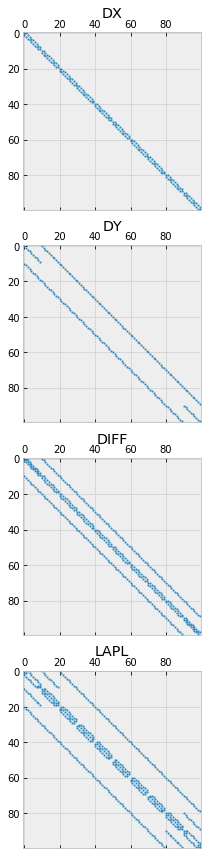

In [68]:
N = 10
spyfig, axarr = plt.subplots(4,1,figsize=(5,15))
axarr[0].spy(DX(N),precision=0.01,markersize=1)
axarr[0].set_title('DX')
axarr[1].spy(DY(N),precision=0.01,markersize=1)
axarr[1].set_title('DY')
axarr[2].spy(DIFF(N),precision=0.01,markersize=1)
axarr[2].set_title('DIFF')
axarr[3].spy(LAPL(N),precision=0.01,markersize=1)
axarr[3].set_title('LAPL')
plt.show()

## d)
Siehe b)

## e)

In [87]:
field = Field(1.0,1.0,0.05)

def f1(x,y):
    return np.exp(x*y)

def f2(x,y):
    return np.cos(10*x*y)

thisfunc = f1

Nx, Ny = field.shape
for i in range(Nx):
    for j in range(Nx):
        x,y = field.getxy(i,j)
        field[i,j] = thisfunc(x,y)

        

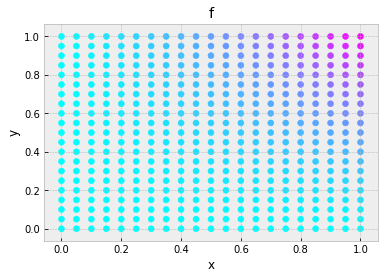

In [88]:
plot = field.plot()
plot.title("f")
plot.show()

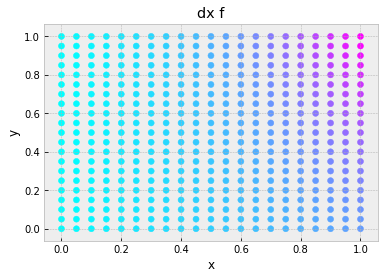

In [89]:
plot = field.dx().plot()
plot.title("dx f")
plot.show()

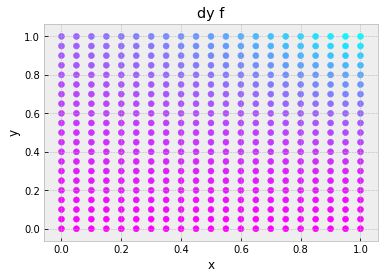

In [90]:
plot = field.dy().plot()
plot.title("dy f")
plot.show()

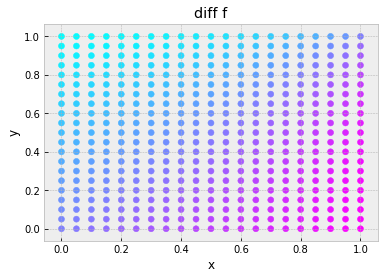

In [91]:
plot = field.diff().plot()
plot.title("diff f")
plot.show()

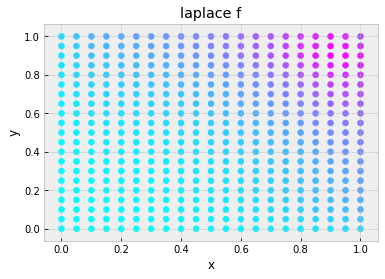

In [92]:
plot = field.lapl().plot()
plot.title("laplace f")
plot.show()